## Setup

In [1]:
%run setup.ipynb
rcParams['savefig.dpi'] = 200

In [2]:
genome = phase2_ar1.genome_agamp3

In [3]:
region_vgsc = SeqFeature('2L', 2358158, 2431617, genome=genome)

In [4]:
len(region_vgsc)

73460

In [5]:
phase2_ar1.load_geneset_agamp44(attributes=['ID', 'Parent'])
geneset_agamp44 = geneset_to_pandas(phase2_ar1.geneset_agamp44)
geneset_agamp44_vgsc = geneset_agamp44.query(region_vgsc.query).copy()
geneset_davies = geneset_to_pandas(allel.FeatureTable.from_gff3('davies_vgsc_model.gff3', attributes=['ID', 'Parent']))
geneset_vgsc_combined = pandas.concat([geneset_agamp44_vgsc, geneset_davies])

In [6]:
tbl_davies_exons = (
    etl
    .fromdataframe(geneset_davies)
    .eq('type', 'CDS')
    .cutout('Parent', 'source', 'type', 'score', 'strand', 'phase')
    .merge(key=('start', 'end'))
    .movefield('seqid', 0)
)

In [7]:
samples = pandas.read_csv(phase2_ar1.samples_fn, sep='\t')

In [8]:
sample_ids = samples.ox_code.values.tolist()
len(sample_ids)

1142

## Plot exons

In [9]:
def plot_exons(features, start, end, ax=None, xytext=None, y=0, height=1, gene_ec='#aaaaaa', gene_fc='none', exon_color='k', label_position='top'):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 1))
        
    # plot whole gene span
    xmin = features.start.min()
    xmax = features.end.max()
    patch = plt.Rectangle((xmin, y), xmax-xmin+1, height, lw=2, edgecolor=gene_ec, facecolor=gene_fc)
    ax.add_patch(patch)
    
    for _, feature in features.iterrows():

        if feature.end >= start and feature.start <= end:
            x = feature.start
            width = feature.end - feature.start + 1
            patch = plt.Rectangle((x, y), width, height, lw=.2, edgecolor='k', facecolor='k')
            ax.add_patch(patch)
            
            try:
                xyt = xytext[feature.ID]
            except:
                xyt = (0, 8)
            if label_position == 'top':
                xy = (x + width/2, y + height)
                va = 'bottom'
                # leave xyt
            else:
                xy = (x + width/2, y)
                xyt = xyt[0], -xyt[1]
                va = 'top'
            ax.annotate(feature.ID, xy=xy, xytext=xyt, textcoords='offset points', ha='center', va=va, 
                        arrowprops=dict(arrowstyle='-', shrinkA=0, shrinkB=0, lw=.5, color='grey'))

    ax.set_xlim(start, end)
    ax.set_ylim(0, 1)
    
    
def plot_davies_exons(start, end, y=0, height=1, ax=None, label_position='top'):
    df = tbl_davies_exons.select('ID', lambda v: '-' not in v).todataframe()
    plot_exons(df, start=start, end=end, ax=ax, label_position=label_position,
               xytext={'7': (-5, 8),
                       '9': (3, 8),
                       '10': (4, 8),
                       '14': (3, 8),
                       '15': (-5, 8),
                       '17': (5, 8),
                       '18b+': (-7, 8),
                       '20c': (5, 8),
                       '20d': (-5, 8),
                       '21': (-4, 8),
                       '23f+': (-4, 8),
                       '24h+': (0, 16),
                       '25': (2, 8),
                       '26': (7, 16),
                       '27k': (5, 8),
                       '28': (-6, 16),
                       '29': (-1, 8),
                       '30': (0, 16),
                       '31': (2, 8),
                       '32': (4, 16),
                        },
               y=y, height=height)
    ax.set_ylim(-.1, 1.1)
    ax.set_yticks([])
    labels = 'exon', 
    handles = [plt.Rectangle((0, 0), 1, 1, color='k')]
    ax.legend(handles=handles, labels=labels, loc='center right', bbox_to_anchor=(0, .5))


## Plot sequence composition

In [10]:
def plot_seq_composition(genome, seqid, start, end, n_bins=500, ax=None, colors=None):

    # obtain reference sequence as numpy char array
    seq = np.asarray(genome[seqid])[start-1:end]

    # convert to lower-case
    seq = np.char.lower(seq)

    # locate nucleotides
    is_a = seq == b'a'
    is_c = seq == b'c'
    is_g = seq == b'g'
    is_t = seq == b't'
    is_n = seq == b'n'
    is_other = ~is_a & ~is_c & ~is_g & ~is_t & ~is_n
    assert np.sum(is_other) == 0

    # construct bins
    bins = np.linspace(0, len(seq), n_bins).astype(int)

    # count nucleotides
    h_a, _ = np.histogram(np.nonzero(is_a)[0], bins=bins)
    h_c, _ = np.histogram(np.nonzero(is_c)[0], bins=bins)
    h_g, _ = np.histogram(np.nonzero(is_g)[0], bins=bins)
    h_t, _ = np.histogram(np.nonzero(is_t)[0], bins=bins)
    h_n, _ = np.histogram(np.nonzero(is_n)[0], bins=bins)

    # plot
    left = bins[:-1] + start
    bottom = 0
    width = np.diff(bins)
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 1))
    if colors is None:
        palette = sns.color_palette('colorblind')
        colors = [palette[i] for i in [1, 0, 2, 4]] + ['k']
    else:
        assert len(colors) == 5, 'bad colors'
    for h, c, l in zip([h_a, h_t, h_g, h_c, h_n], colors, 'ATGCN'):
        ax.bar(left, h, width=width, bottom=bottom, color=c, align='edge', label=l)
        bottom += h
    ax.set_xlim(start, end)
    ax.set_yticks(ax.get_ylim())
    ax.set_yticklabels(['0%', '100%'])
    ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
    
    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[::-1], labels[::-1], loc='center left', bbox_to_anchor=(1, .5), prop=dict(family='monospace'), borderpad=0, ncol=2)
    

## Plot accessibility

In [11]:
def plot_accessibility(accessibility, seqid, start, end, n_bins, ax=None, colors=None):
 
    # extract accessibility map
    is_accessible = accessibility[seqid]['is_accessible'][start-1:end]

    # construct bins
    bins = np.linspace(0, len(is_accessible), n_bins).astype(int)

    # count bases
    h_a, _ = np.histogram(np.nonzero(is_accessible)[0], bins=bins)
    h_n, _ = np.histogram(np.nonzero(~is_accessible)[0], bins=bins)

    # plot
    left = bins[:-1] + start
    bottom = 0
    width = np.diff(bins)
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 1))
    if colors is None:
        colors = 'grey', 'w'
    else:
        assert len(colors) == 2, 'bad colors'
    for h, c, l in zip([h_n, h_a], colors, ['inaccessible', 'accessible']):
        ax.bar(left, h, width=width, bottom=bottom, color=c, align='edge', label=l)
        bottom += h
    ax.set_xlim(start, end)
    ax.set_yticks(ax.get_ylim())
    ax.set_yticklabels(['0%', '100%'])
    ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])

    # legend
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:-1], labels[:-1], loc='center left', bbox_to_anchor=(1, .5), borderpad=0)



## Plot repeats

In [12]:
repeats = geneset_to_pandas(allel.FeatureTable.from_gff3(os.path.join(phase2_ar1.genome_dir, 'agamP4',
                                                                      'Anopheles-gambiae-PEST_REPEATFEATURES_AgamP4.sorted.gff3.gz'),
                                                         attributes=['Name', 'class', 'repeat_consensus', 'Alias', 'ID']))

In [13]:
seqid, start, end = region_vgsc
start = start - 5000
end = end + 5000
repeats_vgsc = repeats.query("(seqid == %r) & (end >= %s) & (start <= %s)" % (seqid, start, end)).copy()

In [14]:
repeats_vgsc['class'].value_counts()

dust               82
trf                32
DNA                32
DNA/Tc1            13
DNA/Harbinger       8
DNA/Pegasus         6
LINE/RTE            6
LINE/GambolFam5     5
DNA/hAT             5
SINE?               5
RC/Helitron         5
DNA/P               4
LINE/IFam5          3
LINE/IFam3          3
transposon          2
LTR/Gypsy           2
LINE/CR1Fam9        2
LINE/CR1Fam28       2
Unknown             2
LINE/IFam7          1
.                   1
LINE/R1Fam7         1
LINE/LonerFam1      1
LINE/L2Fam2         1
LTR/Pao             1
LINE/CR1Fam12       1
LINE/CR1Fam21       1
MITE                1
LINE/CR1Fam20       1
Name: class, dtype: int64

In [15]:
def plot_repeats(features, y=0, height=1, label=None, ax=None, color=None, color_key=None, skip_label=None, label_rotation=90, yt=.8):
    
    if ax is None:
        fig, ax = plt.subplots(figsize=(7, 1))
        
    n_features = len(features)
    
    for i, (_, feature) in enumerate(features.iterrows()):
        
        # feature coords
        x = feature.start
        width = feature.end - feature.start + 1
        if color:
            if callable(color_key):
                k = color_key(feature)
            else:
                k = feature[color_key]
            try:
                c = color[k]
            except KeyError:
                c = 'grey'
        else:
            c = 'grey'
        patch = plt.Rectangle((x, y), width, height, lw=.2, edgecolor=c, facecolor=c)
        ax.add_patch(patch)

        if label:
            # text coords
            xt = i / n_features
            s = feature[label]
            if skip_label and s in skip_label:
                pass
            else:
                ax.annotate(s, xy=(x + width/2, y + height), xycoords='data', xytext=(xt, yt), textcoords='axes fraction', ha='center', va='bottom', 
                            arrowprops=dict(arrowstyle='-', shrinkA=1, shrinkB=0, lw=.5, color='#aaaaaa', relpos=(0.5, 0)), rotation=label_rotation)

    ax.set_yticks([])
    return ax


In [16]:
def plot_all_repeats(seqid, start, end, label_tes=True, ax=None, y_rm=2, y_trf=1, y_dust=0, height=.9, skip_label=None, label_rotation=90, yt=.8):

    repeats_sel = repeats.query("(seqid == %r) & (end >= %s) & (start <= %s)" % (seqid, start, end)).copy()

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 1))
        sns.despine(ax=ax, left=True)

    palette = sns.color_palette('Set2', 9)

    # DUST, TRF
    repeat_color = {
        'dust': palette[4],
        'TRF': palette[5],    
    }
    plot_repeats(repeats_sel[repeats_sel.source == 'dust'], y=y_dust, height=height, ax=ax, 
                 color=repeat_color, color_key='source')
    plot_repeats(repeats_sel[repeats_sel.source == 'TRF'], y=y_trf, height=height, ax=ax, 
                 color=repeat_color, color_key='source')

    # repeat-masker
    repeat_color = {
        'LINE': palette[0],
        'SINE?': palette[1],
        'LTR': palette[2],
        'DNA': palette[3],
        'RC': palette[3],
        'MITE': palette[3],

    }
    if label_tes:
        label = 'class'
    else:
        label = None
    plot_repeats(repeats_sel[repeats_sel.source == 'RepeatMasker'], y=y_rm, height=height, ax=ax, label=label,
                 skip_label=skip_label, label_rotation=label_rotation, yt=yt,
                 color=repeat_color, color_key=lambda v: v['class'].split('/')[0])

    labels = 'LINE', 'SINE', 'LTR', 'Class II (DNA)', 'low complexity (DUST)', 'tandem repeat (TRF)'
    handles = [plt.Rectangle((0, 0), 1, 1, color=palette[i]) for i in [0, 1, 2, 3, 4, 5]]
    ax.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(1, .5), ncol=2)
    ax.set_xlim(start, end)
    if label_tes:
        ax.set_ylim(-.2, 10)
    else:
        ax.set_ylim(-.2, 3)

TODO: fix repeat and exon plotting so only annotate if within bounds.

## Setup alignment stats

In [17]:
alignment_stats = zarr.open_group('/kwiat/vector/ag1000g/release/phase2.AR1/alignment_stats/stats.zarr2', mode='r')
alignment_stats

Group(/, 1)
  groups: 1; 2L
  store: DirectoryStore

In [18]:
@cache.memoize
def average_coverage(seqid, sample_id):
    reads_all = alignment_stats[seqid]['reads_all']
    # check to see if built
    if sample_id in reads_all.attrs:
        sample_idx = sample_ids.index(sample_id)
        x = reads_all[:, sample_idx]
        xnz = x[x > 0]
        mean = np.mean(xnz)
        median = np.median(xnz)
        mode = np.argmax(np.bincount(xnz))
        std = np.std(xnz)
        return mean, median, mode, std
    else:
        raise ValueError('stats not built')


In [19]:
average_coverage('2L', 'AA0040-C')

(29.707038168791755, 30.0, 31, 13.558599323762076)

In [36]:
selected_sample_ids = []
for s in phase2_ar1.sample_ids:
    try:
        # for now, only use ones that have alignment data
        average_coverage('2L', s)
        selected_sample_ids.append(s)
    except ValueError:
        pass

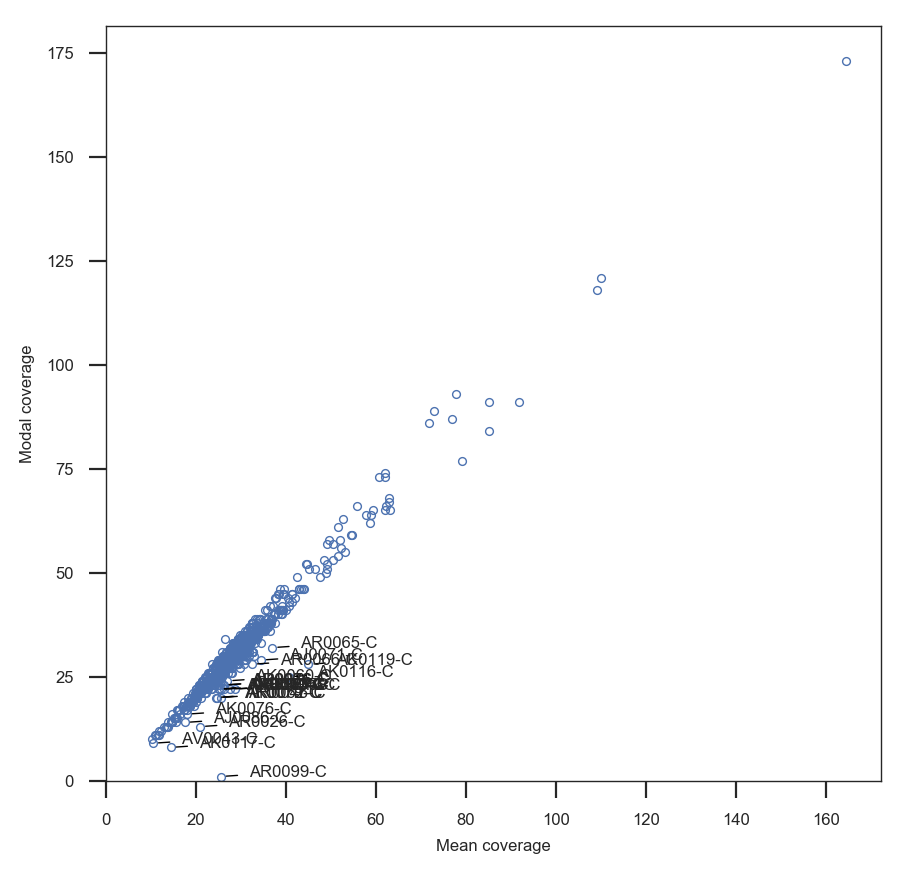

In [39]:
# check skew
blacklist_sample_ids = []
v = np.array([average_coverage('2L', s) for s in selected_sample_ids])
fig, ax = plt.subplots(figsize=(5, 5))
ax.plot(v[:, 0], v[:, 2], linestyle=' ', marker='.', mfc='none')
ax.set_xlabel('Mean coverage')
ax.set_ylabel('Modal coverage')
for m, d, s in zip(v[:, 0], v[:, 2], selected_sample_ids):
    if m - d > (.1 * m):
        ax.annotate(s, xy=(m, d), xytext=(10, 0), textcoords='offset points', arrowprops=dict(arrowstyle='-'))
        blacklist_sample_ids.append(s)
ax.set_xlim(left=0)
ax.set_ylim(bottom=0);

In [40]:
whitelist_sample_ids = [s for s in selected_sample_ids if s not in blacklist_sample_ids]
len(whitelist_sample_ids)

1000

In [42]:
phase2_ar1.samples.head()

src_code population country       region    contributor  \
ox_code                                                                    
AA0040-C  Twifo_Praso__E2      GHcol   Ghana  Twifo_Praso  David Weetman   
AA0041-C  Twifo_Praso__H3      GHcol   Ghana  Twifo_Praso  David Weetman   
AA0042-C      Takoradi_C7      GHcol   Ghana     Takoradi  David Weetman   
AA0043-C      Takoradi_H8      GHcol   Ghana     Takoradi  David Weetman   
AA0044-C     Takoradi_D10      GHcol   Ghana     Takoradi  David Weetman   

         contact    year m_s sex  n_sequences  mean_coverage  
ox_code                                                       
AA0040-C     NaN  2012.0   M   F     95033368          30.99  
AA0041-C     NaN  2012.0   M   F     95843804          31.70  
AA0042-C     NaN  2012.0   M   F    107420666          35.65  
AA0043-C     NaN  2012.0   M   F     95993752          29.46  
AA0044-C     NaN  2012.0   M   F    103044262          33.67

In [43]:
whitelist_samples = phase2_ar1.samples.loc[whitelist_sample_ids]
whitelist_samples.head()

src_code population country       region    contributor  \
ox_code                                                                    
AA0040-C  Twifo_Praso__E2      GHcol   Ghana  Twifo_Praso  David Weetman   
AA0041-C  Twifo_Praso__H3      GHcol   Ghana  Twifo_Praso  David Weetman   
AA0042-C      Takoradi_C7      GHcol   Ghana     Takoradi  David Weetman   
AA0043-C      Takoradi_H8      GHcol   Ghana     Takoradi  David Weetman   
AA0044-C     Takoradi_D10      GHcol   Ghana     Takoradi  David Weetman   

         contact    year m_s sex  n_sequences  mean_coverage  
ox_code                                                       
AA0040-C     NaN  2012.0   M   F     95033368          30.99  
AA0041-C     NaN  2012.0   M   F     95843804          31.70  
AA0042-C     NaN  2012.0   M   F    107420666          35.65  
AA0043-C     NaN  2012.0   M   F     95993752          29.46  
AA0044-C     NaN  2012.0   M   F    103044262          33.67

In [46]:
whitelist_samples.population.value_counts()

CMgam    267
UGgam    101
BFgam     85
GW        79
BFcol     63
CIcol     62
GAgam     60
GM        58
GHcol     54
AOcol     53
KE        40
GNgam     36
FRgam     22
GQgam      9
GHgam      7
GNcol      4
Name: population, dtype: int64

In [47]:
phase2_ar1.pop_ids

('AOcol',
 'BFcol',
 'GHcol',
 'CIcol',
 'GNcol',
 'GW',
 'GM',
 'GNgam',
 'BFgam',
 'GHgam',
 'CMgam',
 'UGgam',
 'GAgam',
 'GQgam',
 'FRgam',
 'KE')

In [48]:
n_max = 50
ds_sample_ids = []
for pop in phase2_ar1.pop_ids:
    l = whitelist_samples[whitelist_samples.population == pop].index.values.tolist()
    if len(l) > n_max:
        l = random.sample(l, n_max)
    ds_sample_ids.extend(l)
# scramble order
ds_sample_ids = random.sample(ds_sample_ids, len(ds_sample_ids))
len(ds_sample_ids)

618

In [49]:
@cache.memoize
def normalized_coverage(seqid, start, end, selected_sample_ids, average='mode', convolve=None):

    # extract raw coverage
    loc = slice(start - 1, end)
    reads_all = alignment_stats[seqid]['reads_all'][loc, :]

    # extract for selected samples
    sample_idxs = [sample_ids.index(s) for s in selected_sample_ids]
    reads_all_sel = np.take(reads_all, sample_idxs, axis=1)

    # normalize 
    norm_idx = ['mean', 'median', 'mode'].index(average)
    norm = np.array([average_coverage(seqid, s)[norm_idx] for s in selected_sample_ids])
    reads_all_norm = reads_all_sel * 2 / norm[None, :]
    
    # smooth
    if convolve is not None:
        out = np.zeros_like(reads_all_norm)
        for i in range(out.shape[1]):
            out[:, i] = np.convolve(reads_all_norm[:, i], convolve, mode='same')
    else:
        out = reads_all_norm

    return out

In [56]:
def plot_normalized_coverage(seqid, start, end, selected_sample_ids, average='mode', ax=None, plot_kwargs=None, 
                             convolve=None, color_field='population', colors=None, color_keys=None):
 
    # setup
    if color_keys is None:
        samples = phase2_ar1.samples
        color_keys = samples[color_field][selected_sample_ids]
    reads_all_norm = normalized_coverage(seqid=seqid, start=start, end=end, selected_sample_ids=selected_sample_ids, average=average, convolve=convolve)

    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 4))

    x = np.arange(start, end + 1)
    if plot_kwargs is None:
        plot_kwargs = dict()
    plot_kwargs.setdefault('lw', .1)
    plot_kwargs.setdefault('linestyle', '-')
    for i, (s, k) in enumerate(zip(selected_sample_ids, color_keys)):
        y = reads_all_norm[:, i]
        ax.plot(x, y, color=colors[k], **plot_kwargs)

    ax.set_ylim(0, 12)
    ax.set_yticks(range(13))
    ax.grid(axis='y')
    
    # legend
    labels = color_keys.unique().tolist()
    handles = [plt.Rectangle((0, 0), 1, 1, color=colors[l]) for l in labels] 
    ax.legend(loc='center left', bbox_to_anchor=(1, .5), handles=handles, labels=labels)
    
    return ax

## Add MQ0

In [52]:
def plot_accessibility_metric(accessibility, metric, seqid, start, end, ax=None, color=None):
 
    # extract accessibility metric
    y = accessibility[seqid][metric][:]
    ymax = np.max(y)
    y = y[start-1:end] 

    # plot
    x = np.arange(start, end + 1)
    if ax is None:
        fig, ax = plt.subplots(figsize=(15, 1))
    ax.fill_between(x, 0, y, color=color, label=metric)
    ax.set_xlim(start, end)
    ax.set_yticks([0, ymax])
    ax.set_ylim(0, ymax)
    ax.set_yticklabels(['0%', '100%'])
    ax.set_xticklabels(['{:,}'.format(int(x)) for x in ax.get_xticks()])
    ax.legend(loc='center left', bbox_to_anchor=(1, .5))



In [69]:
def plot_diagnostics_v2(genome, seqid, start, end, selected_sample_ids, n_bins=1000, label_tes=True, convolve_coverage=None, 
                        coverage_color_field='population', coverage_colors=None, coverage_color_keys=None, coverage_plot_kwargs=None):

    accessibility = phase2_ar1.accessibility

    fig = plt.figure(figsize=(15, 7))
    gs = mpl.gridspec.GridSpec(8, 1, height_ratios=[5, 1.5, .5, .5, .5, .5, .5, .7], hspace=0.1)
    row = -1

    # coverage
    ##########
    row += 1
    ax = fig.add_subplot(gs[row, 0])
    sns.despine(ax=ax, left=True, bottom=True)
    plot_normalized_coverage(seqid, start, end, selected_sample_ids, ax=ax, convolve=convolve_coverage, 
                             color_field=coverage_color_field, colors=coverage_colors, color_keys=coverage_color_keys,
                             plot_kwargs=coverage_plot_kwargs)
    ax.set_xticks([])
    ax.set_xlim(start, end)
    ax.set_ylim(-0.1, 12)
    ax.set_ylabel('Normalized coverage')

    # repeats and exons
    ###################
    row += 1
    ax = fig.add_subplot(gs[row, 0])
    sns.despine(ax=ax, left=True, bottom=True)
    plot_davies_exons(start=start, end=end, ax=ax, y=0, height=.7, label_position='bottom')
    plot_all_repeats(seqid, start, end, label_tes=label_tes, y_rm=0, y_dust=0, y_trf=0, height=.7, ax=ax, label_rotation=0, yt=.9)
    ax.set_xticks([])
    ax.set_xlim(start, end)
    if label_tes:
        ax.set_ylim(-.8, 1.5)
    else:
        ax.set_ylim(-.8, 1)

    # accessibility
    ###############

    row += 1
    ax = fig.add_subplot(gs[row, 0])
    plot_accessibility(accessibility, seqid, start, end, ax=ax, n_bins=n_bins)
    ax.set_xticks([])
    ax.set_xlim(start, end)

    row += 1
    ax = fig.add_subplot(gs[row, 0])
    sns.despine(ax=ax)
    plot_accessibility_metric(accessibility, 'high_mq0', seqid, start, end, ax=ax, color='orange')
    ax.set_xticks([])
    ax.set_xlim(start, end)
    ax.axhline(y=1, linestyle=':', color='grey')
    ax.set_ylim(0, 10)
    ax.set_yticks([0, 10])
    ax.set_yticklabels([0, 10])

    row += 1
    ax = fig.add_subplot(gs[row, 0])
    sns.despine(ax=ax)
    plot_accessibility_metric(accessibility, 'no_coverage', seqid, start, end, ax=ax, color='#333333')
    ax.set_xticks([])
    ax.set_xlim(start, end)
    ax.axhline(y=1, linestyle=':', color='grey')
    ax.set_ylim(0, 10)
    ax.set_yticks([0, 10])
    ax.set_yticklabels([0, 10])

    row += 1
    ax = fig.add_subplot(gs[row, 0])
    sns.despine(ax=ax)
    plot_accessibility_metric(accessibility, 'low_coverage', seqid, start, end, ax=ax, color='blue')
    ax.set_xticks([])
    ax.set_xlim(start, end)
    ax.axhline(y=114, linestyle=':', color='grey')
    ax.set_ylim(0, 200)
    ax.set_yticks([0, 200])
    ax.set_yticklabels([0, 200])

    row += 1
    ax = fig.add_subplot(gs[row, 0])
    sns.despine(ax=ax)
    plot_accessibility_metric(accessibility, 'high_coverage', seqid, start, end, ax=ax, color='red')
    ax.set_xticks([])
    ax.set_xlim(start, end)
    ax.axhline(y=20, linestyle=':', color='grey')
    ax.set_ylim(0, 50)
    ax.set_yticks([0, 50])
    ax.set_yticklabels([0, 50])

    # sequence composition
    ######################
    row += 1
    ax = fig.add_subplot(gs[row, 0])
    plot_seq_composition(genome, seqid, start, end, ax=ax, n_bins=n_bins)
    ax.set_xlim(start, end)
    
    plt.show()


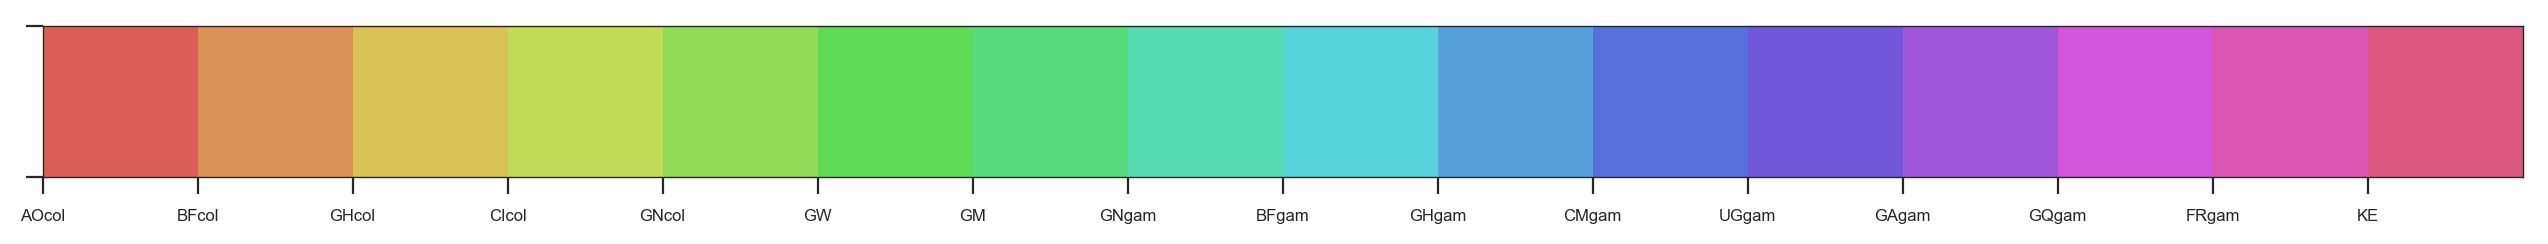

In [70]:
palette = sns.color_palette('hls', n_colors=len(phase2_ar1.pop_ids))
sns.palplot(palette)
plt.gca().set_xticklabels(phase2_ar1.pop_ids);

In [71]:
pop_colors = dict(zip(phase2_ar1.pop_ids, palette))
pop_colors

{'AOcol': (0.86, 0.3712, 0.33999999999999997),
 'BFcol': (0.86, 0.5661999999999999, 0.33999999999999997),
 'BFgam': (0.33999999999999997, 0.8287999999999999, 0.86),
 'CIcol': (0.7638, 0.86, 0.33999999999999997),
 'CMgam': (0.33999999999999997, 0.43879999999999986, 0.86),
 'FRgam': (0.86, 0.33999999999999997, 0.6987999999999996),
 'GAgam': (0.6311999999999998, 0.33999999999999997, 0.86),
 'GHcol': (0.86, 0.7612000000000001, 0.33999999999999997),
 'GHgam': (0.33999999999999997, 0.6337999999999998, 0.86),
 'GM': (0.33999999999999997, 0.86, 0.5012000000000001),
 'GNcol': (0.5688000000000001, 0.86, 0.33999999999999997),
 'GNgam': (0.33999999999999997, 0.86, 0.6962000000000002),
 'GQgam': (0.8261999999999998, 0.33999999999999997, 0.86),
 'GW': (0.3738000000000001, 0.86, 0.33999999999999997),
 'KE': (0.86, 0.33999999999999997, 0.5037999999999996),
 'UGgam': (0.43619999999999975, 0.33999999999999997, 0.86)}

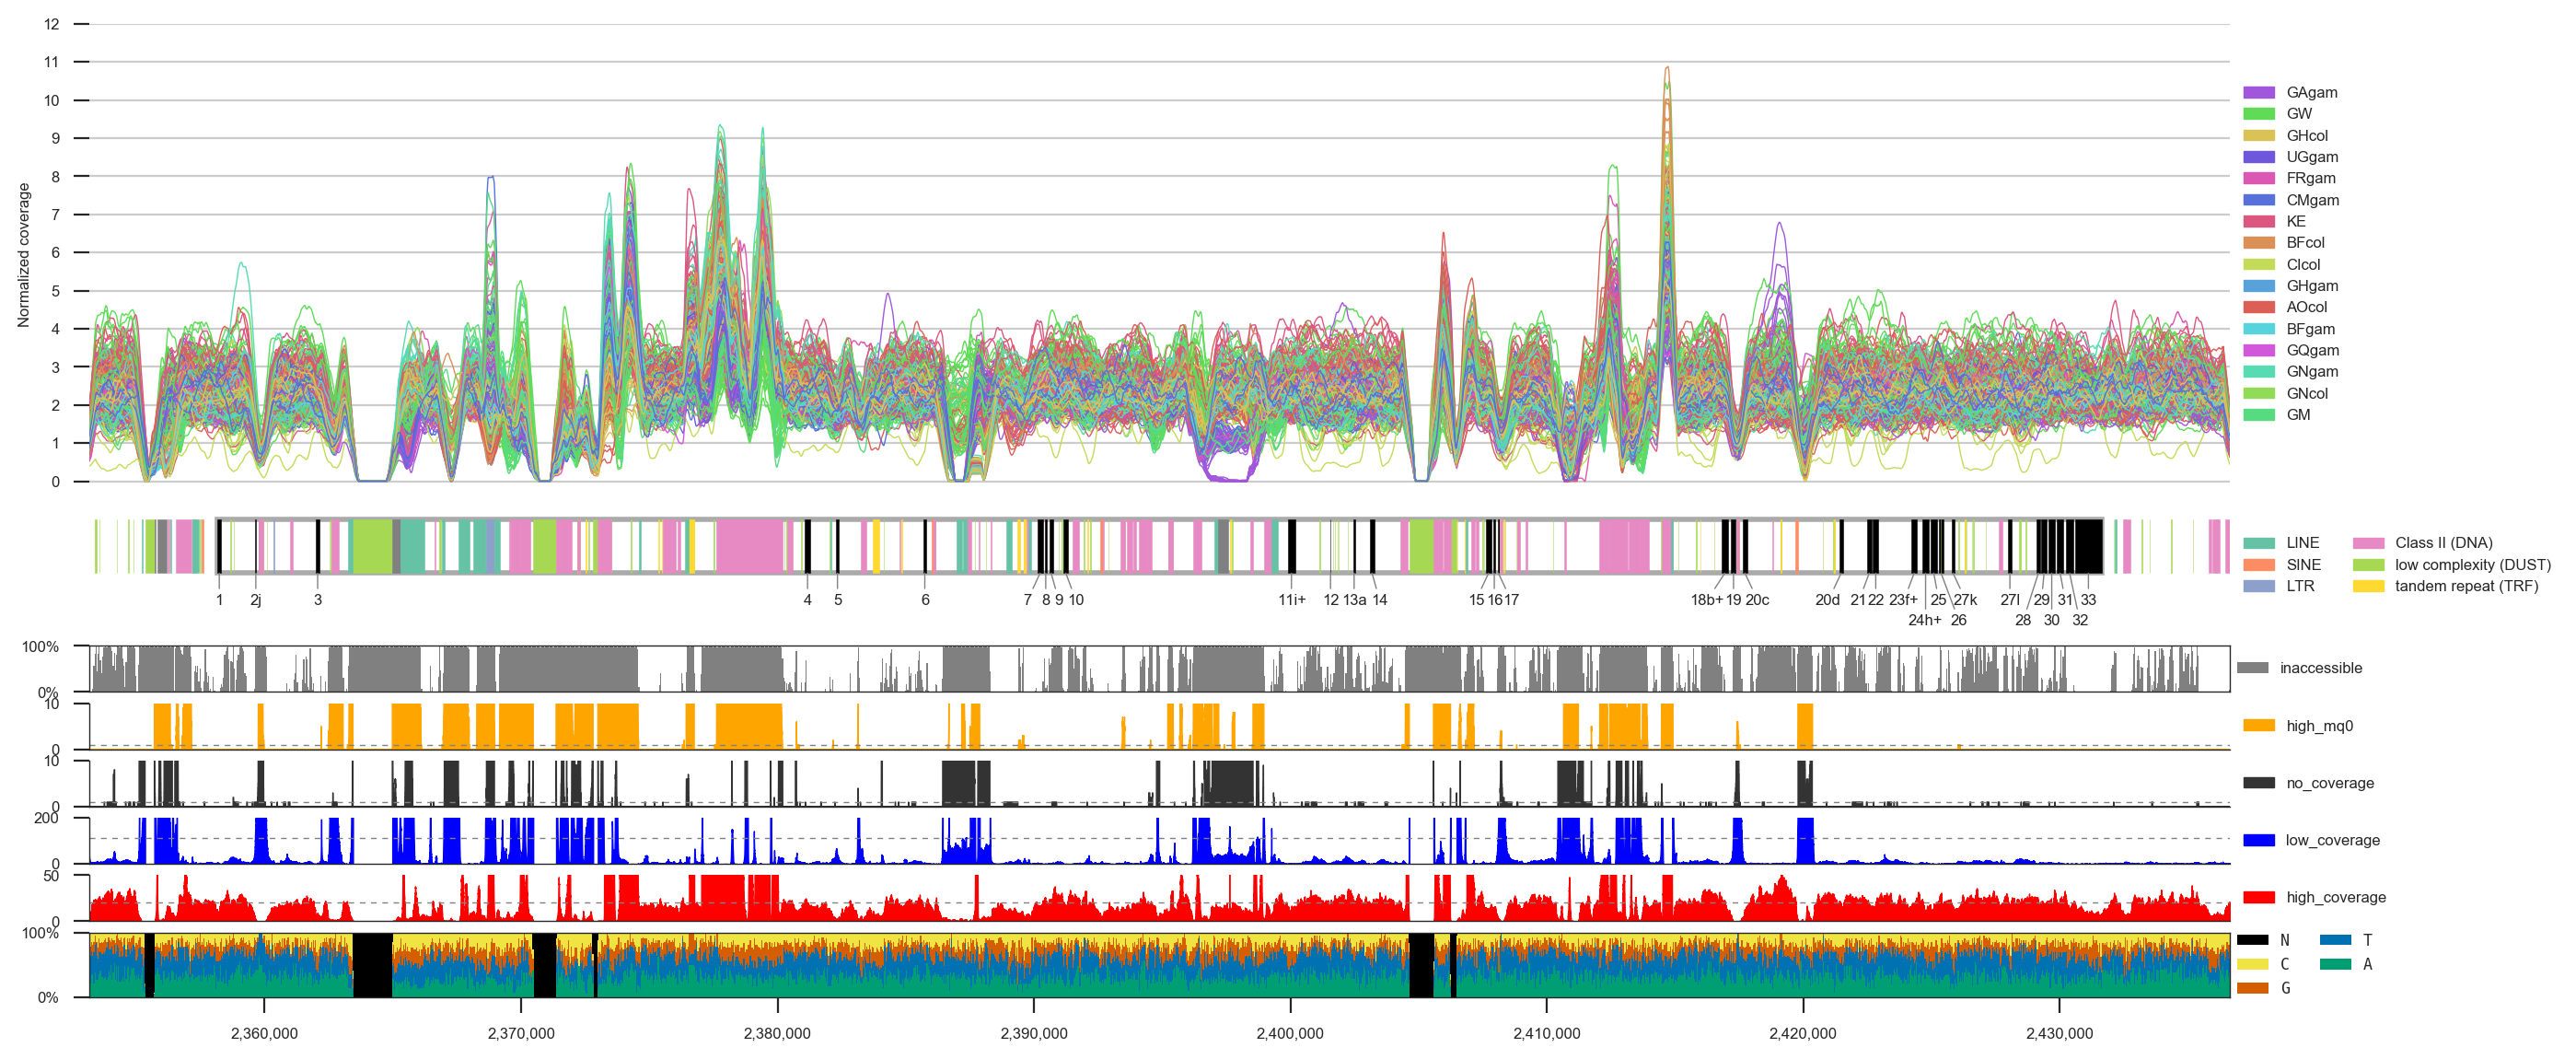

In [72]:
plot_diagnostics_v2(genome, region_vgsc.seqid, region_vgsc.start - 5000, region_vgsc.end + 5000, selected_sample_ids=ds_sample_ids, 
                    n_bins=2000, label_tes=False, convolve_coverage=np.ones(500)/500, coverage_plot_kwargs=dict(lw=.5), coverage_colors=pop_colors)

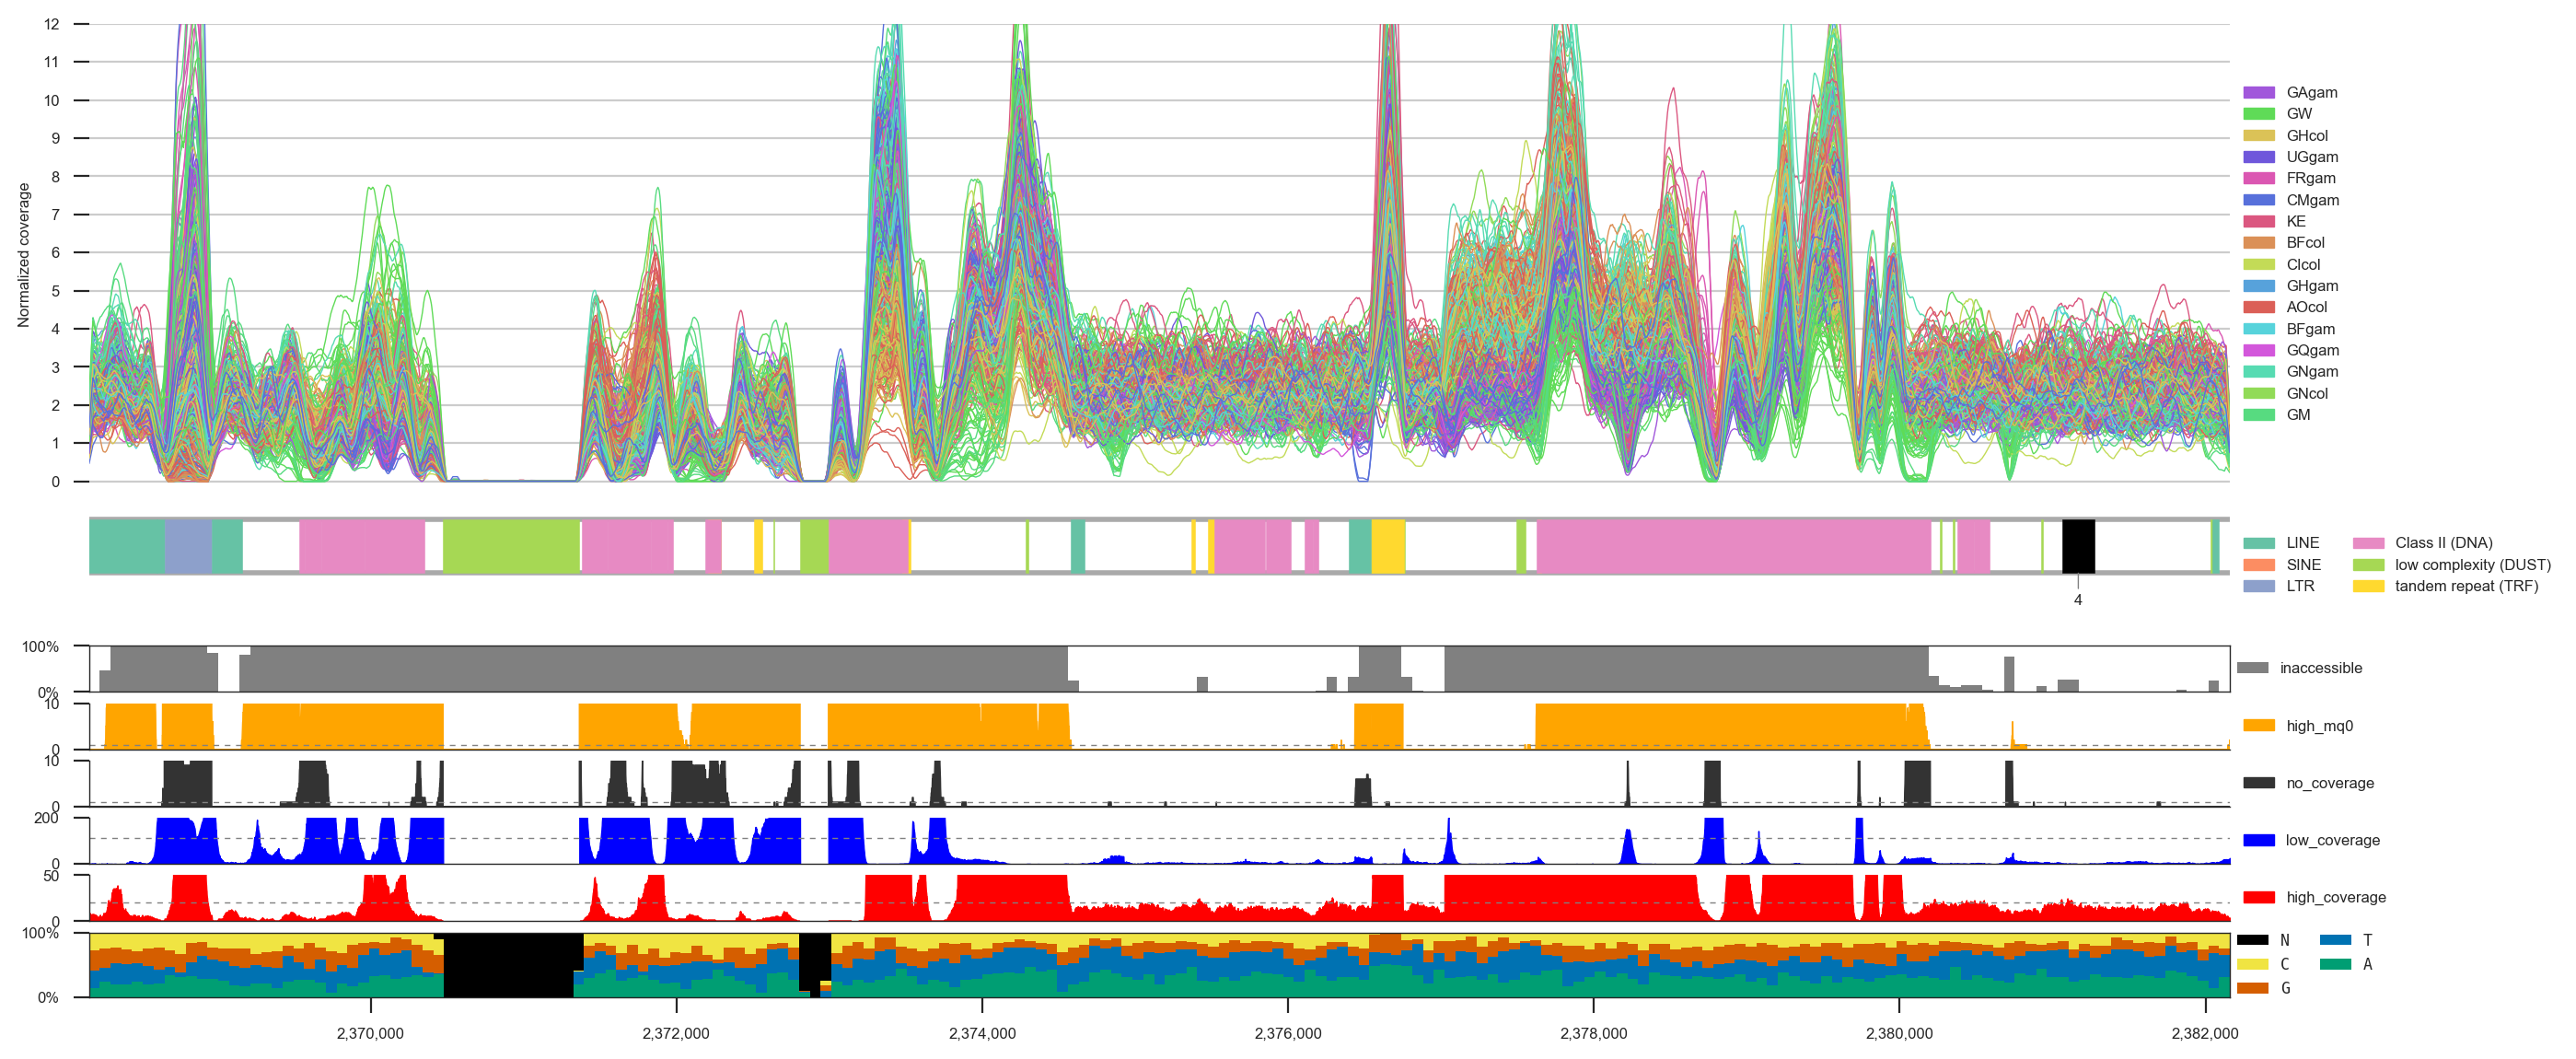

In [73]:
plot_diagnostics_v2(genome, region_vgsc.seqid, region_vgsc.start + 10000, region_vgsc.start + 24000, selected_sample_ids=ds_sample_ids, 
                    n_bins=200, label_tes=False, convolve_coverage=np.ones(50)/50, coverage_plot_kwargs=dict(lw=.5), coverage_colors=pop_colors)

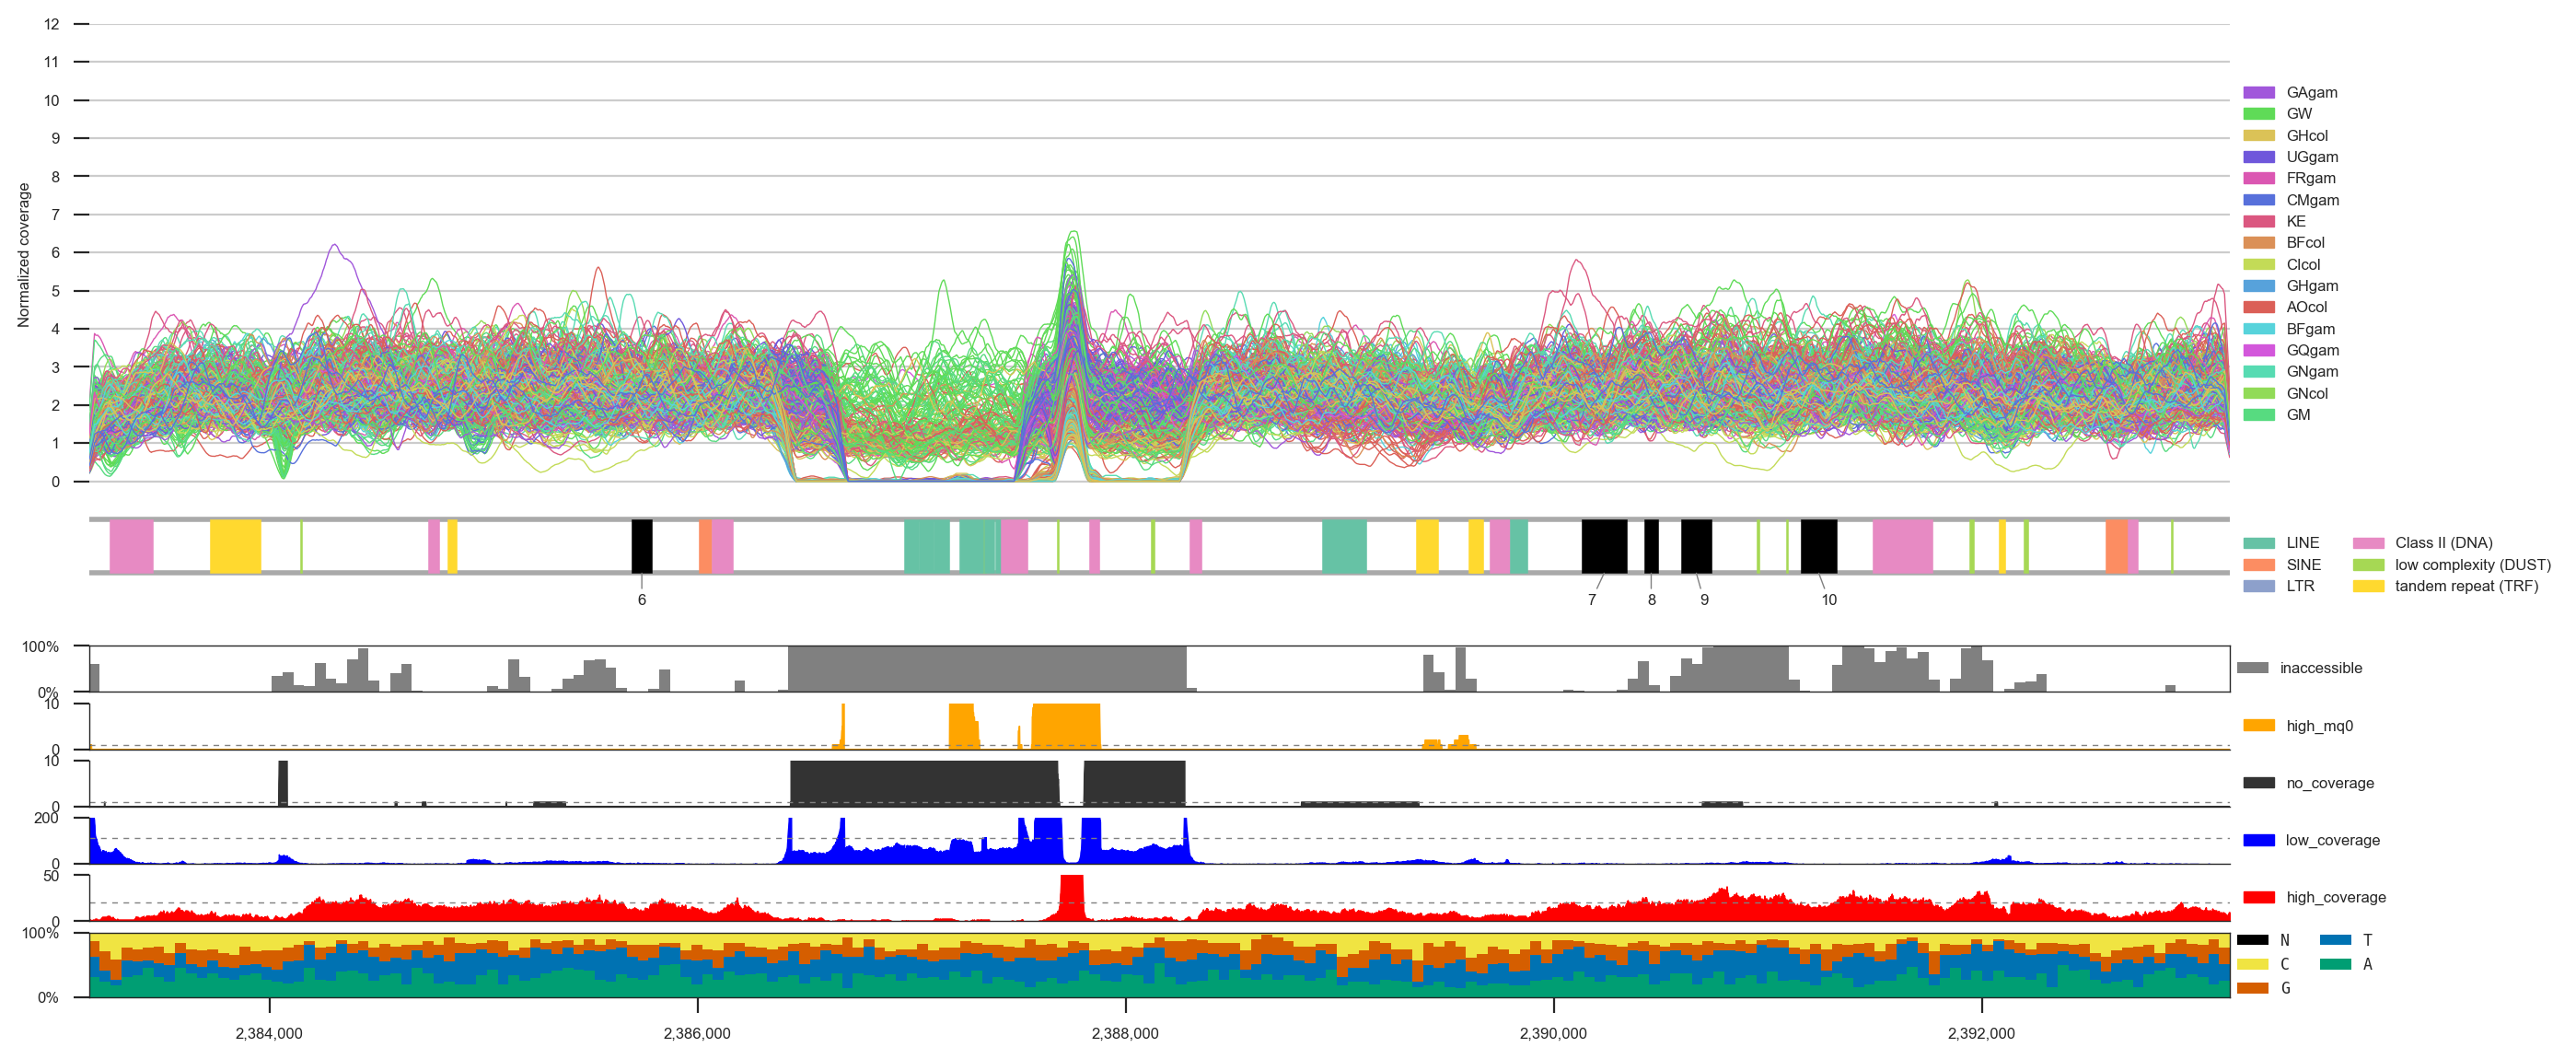

In [74]:
plot_diagnostics_v2(genome, region_vgsc.seqid, region_vgsc.start + 25000, region_vgsc.start + 35000, selected_sample_ids=ds_sample_ids, 
                    n_bins=200, label_tes=False, convolve_coverage=np.ones(50)/50, coverage_plot_kwargs=dict(lw=.5), coverage_colors=pop_colors)

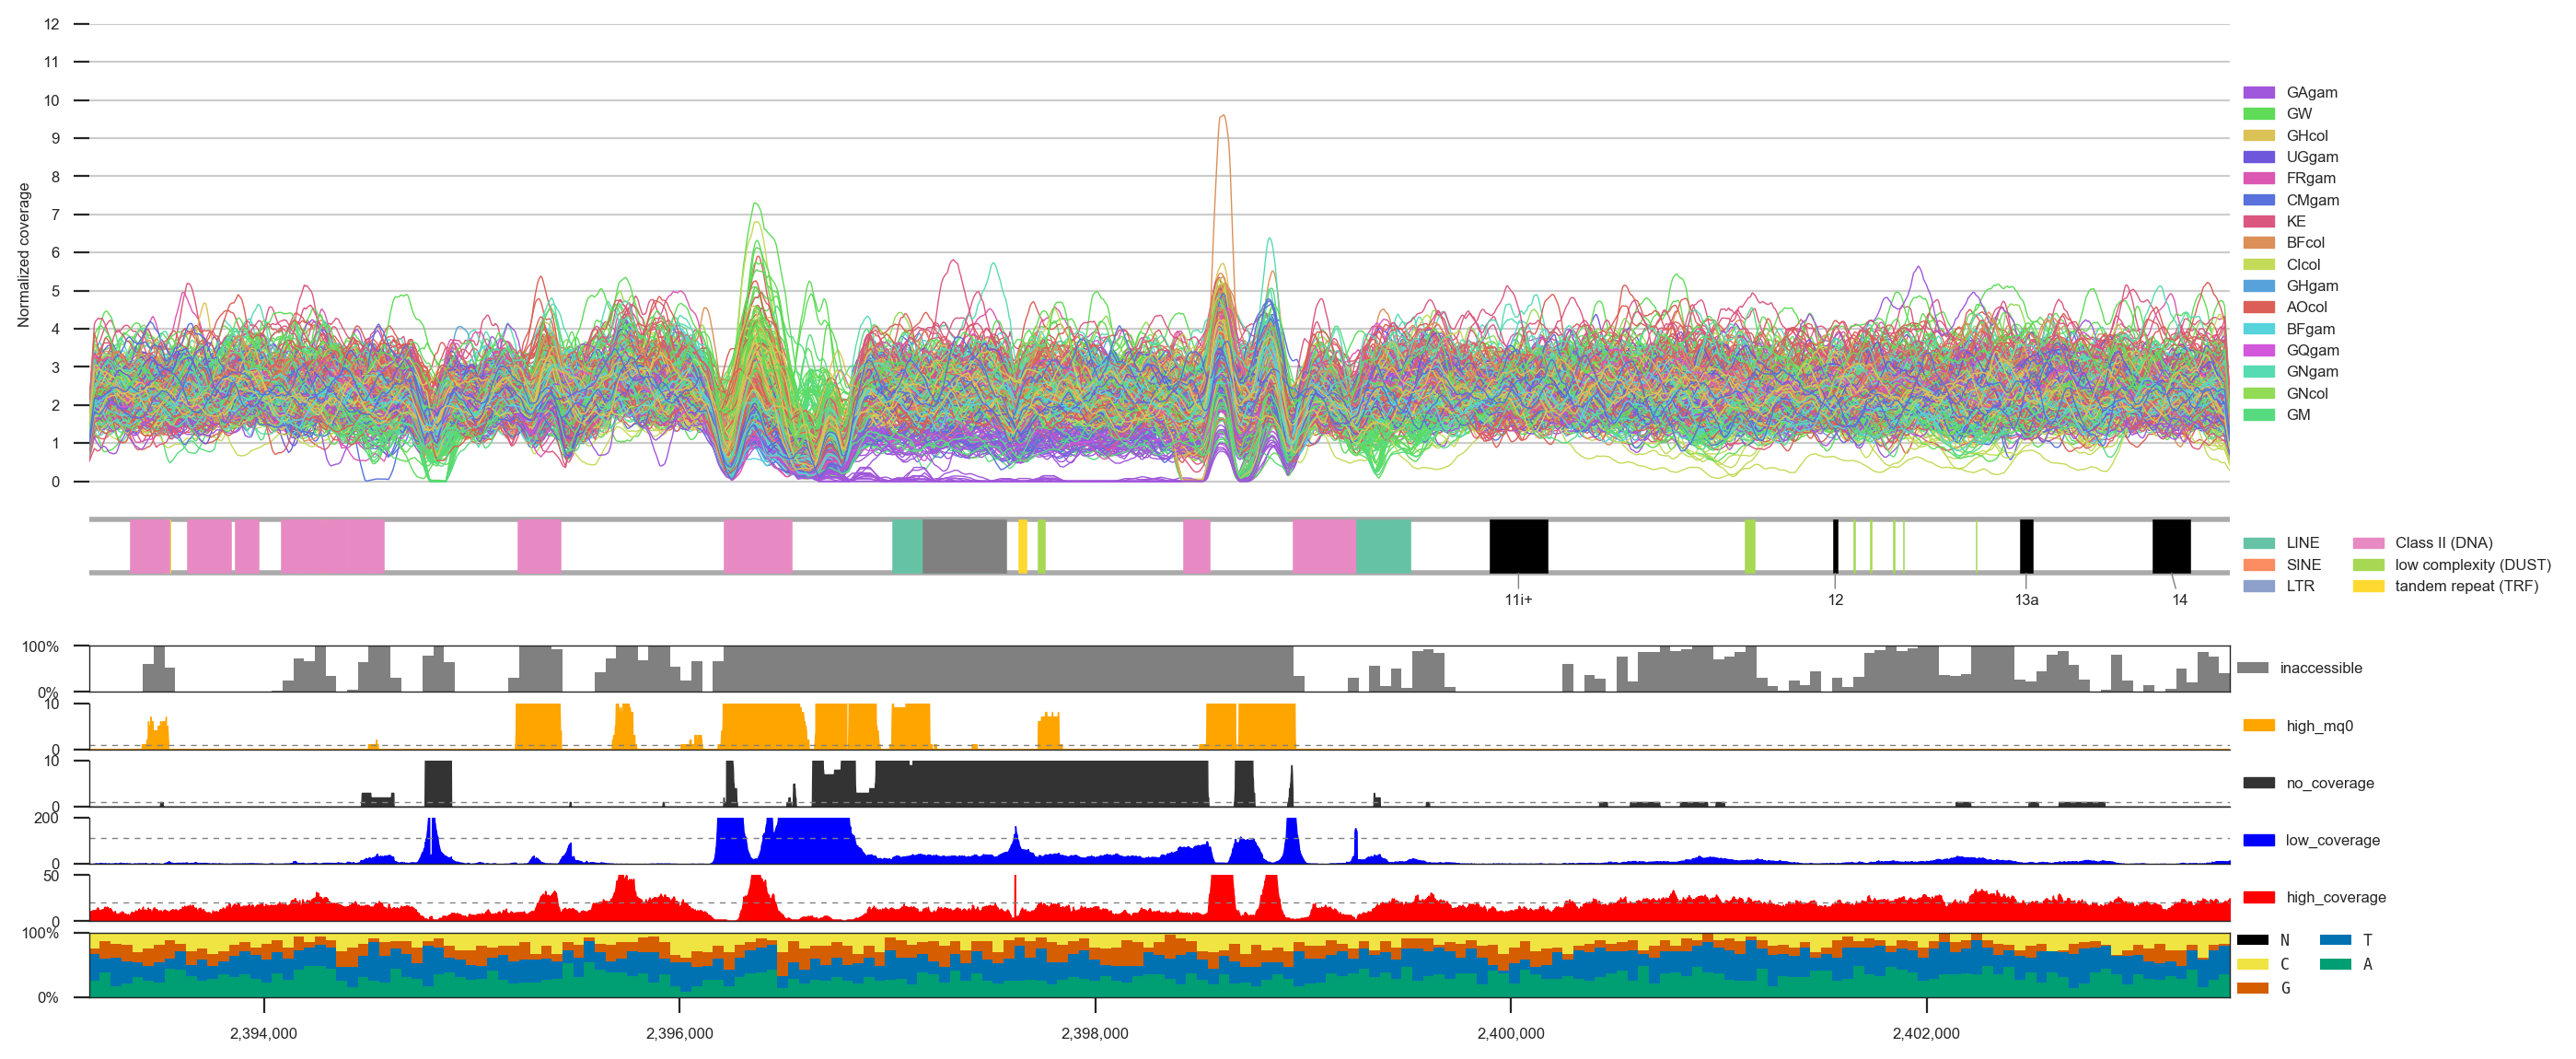

In [75]:
plot_diagnostics_v2(genome, region_vgsc.seqid, region_vgsc.start + 35000, region_vgsc.start + 45300, selected_sample_ids=ds_sample_ids, 
                    n_bins=200, label_tes=False, convolve_coverage=np.ones(50)/50, coverage_plot_kwargs=dict(lw=.5), coverage_colors=pop_colors)

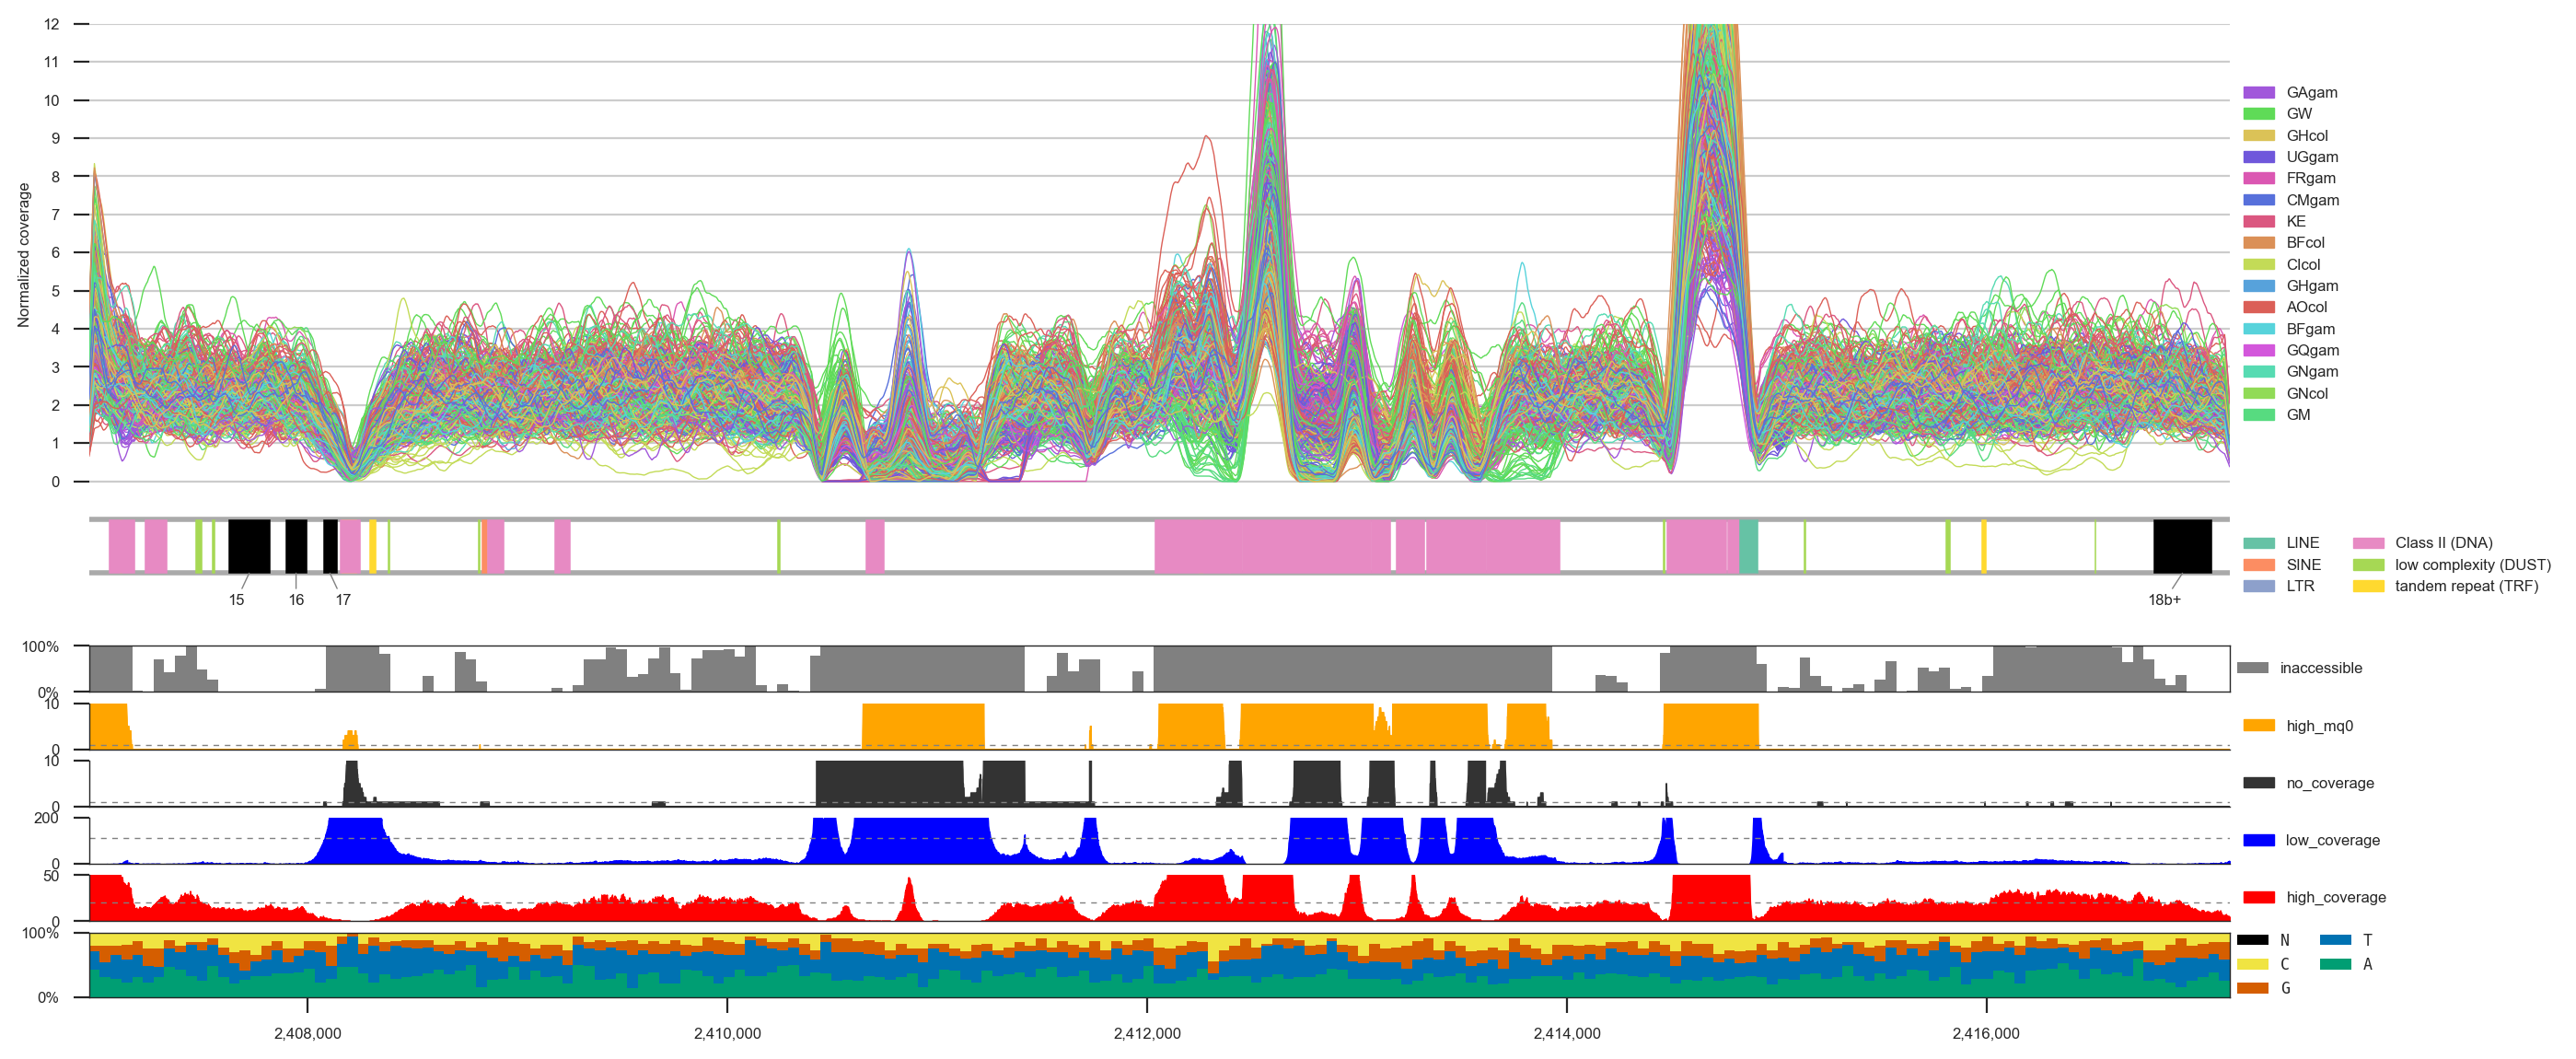

In [76]:
plot_diagnostics_v2(genome, region_vgsc.seqid, region_vgsc.start + 48800, region_vgsc.start + 59000, selected_sample_ids=ds_sample_ids, 
                    n_bins=200, label_tes=False, convolve_coverage=np.ones(50)/50, coverage_plot_kwargs=dict(lw=.5), coverage_colors=pop_colors)